## Image Captioning
- Generating Captions for Images

### Steps 
- Data collection
- Understanding the data
- Data Cleaning
- Loading the training set
- Data Preprocessing — Images
- Data Preprocessing — Captions
- Data Preparation using Generator Function
- Word Embeddings
- Model Architecture
- Inference

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import re
import string
import json
from time import time
import pickle
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers.merge import add

In [5]:
# Read Text Captions

def readTextFile(path):
    with open(path) as f:
        captions = f.read()
    return captions
    

In [6]:
captions  = readTextFile("./Data/captions.txt")
captions = captions.split('\n')[:-1]

In [7]:
print(len(captions))

40456


In [8]:
first,second  = captions[0].split(',')
print(first.split(".")[0])
print(second)

image
caption


In [9]:
# Dictionary to Map each Image with the list of captions it has

In [10]:
descriptions = {}
for x in captions:
    first,desc = x.split(",",1)
    image_name = first.split(".")[0]

    # if the image id is already present or not
    if descriptions.get(image_name) is None:
        descriptions[image_name] = []

    descriptions[image_name].append(desc)


In [11]:
descriptions["1000268201_693b08cb0e"]

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

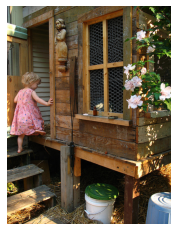

In [12]:
IMG_PATH = "Data/Images/"
import cv2
import matplotlib.pyplot as plt

img = cv2.imread(IMG_PATH+"1000268201_693b08cb0e.jpg")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis("off")
plt.show()



### Data Cleaning


In [13]:
def clean_text(sentence):
    sentence = sentence.lower()
    sentence = re.sub("[^a-z]+"," ",sentence)
    sentence = sentence.split()
    
    sentence  = [s for s in sentence if len(s)>1]
    sentence = " ".join(sentence)
    return sentence
    

In [14]:
clean_text("A cat is sitting over the house # 64")

'cat is sitting over the house'

In [15]:
# Clean all Captions
for key,caption_list in descriptions.items():
    for i in range(len(caption_list)):
        caption_list[i] = clean_text(caption_list[i])

In [16]:
descriptions["1000268201_693b08cb0e"]

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [17]:
# Write the data to text file
with open("descriptions_1.txt","w") as f:
    f.write(str(descriptions))

### Vocabulary 

In [18]:
descriptions = None
with open("descriptions_1.txt",'r') as f:
    descriptions= f.read()
    
json_acceptable_string = descriptions.replace("'","\"")
descriptions = json.loads(json_acceptable_string)

In [19]:
print(type(descriptions))

<class 'dict'>


In [20]:
# Vocab

vocab = set()
for key in descriptions.keys():
    [vocab.update(sentence.split()) for sentence in descriptions[key]]
    
print("Vocab Size : %d"% len(vocab))

Vocab Size : 8425


In [21]:
# Total No of words across all the sentences
total_words = []

for key in descriptions.keys():
    [total_words.append(i) for des in descriptions[key] for i in des.split()]
    
print("Total Words %d"%len(total_words))


Total Words 373804


In [22]:
# Filter Words from the Vocab according to certain threshold frequncy

In [23]:
import collections

counter = collections.Counter(total_words)
freq_cnt = dict(counter)
print(len(freq_cnt.keys()))

8425


In [24]:
# Sort this dictionary according to the freq count
sorted_freq_cnt = sorted(freq_cnt.items(),reverse=True,key=lambda x:x[1])

# Filter
threshold = 10
sorted_freq_cnt  = [x for x in sorted_freq_cnt if x[1]>threshold]
total_words = [x[0] for x in sorted_freq_cnt]

In [25]:
print(len(total_words))

1845


### Prepare Train/Test Data

In [26]:
data = []
for i in descriptions.keys():
    data.append(i)

In [27]:
split = int(8091*0.8)
train = data[0:split]
test  = data[split:]

In [28]:
train[:5]

['image',
 '1000268201_693b08cb0e',
 '1001773457_577c3a7d70',
 '1002674143_1b742ab4b8',
 '1003163366_44323f5815']

In [29]:
# Prepare Description for the Training Data
# Tweak - Add <s> and <e> token to our training data
train_descriptions = {}

for img_id in train:
    if img_id=="image":
        continue
    train_descriptions[img_id] = []
    for cap in descriptions[img_id]:
        cap_to_append = "startseq "  + cap + " endseq"
        train_descriptions[img_id].append(cap_to_append)

In [30]:
# train_descriptions["1000268201_693b08cb0e"]

### Transfer Learning
- Images --> Features
- Text ---> Features 

### Step - 1 Image Feature Extraction

In [31]:
model = ResNet50(weights="imagenet",input_shape=(224,224,3))
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [53]:
model_new = Model(model.input,model.layers[-2].output)
model_new.save('2048_img_model.h5')

C:\Users\issne\miniconda3\envs\ml\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [54]:
def preprocess_img(img):
    img = image.load_img(img,target_size=(224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img,axis=0)
    # Normalisation
    img = preprocess_input(img)
    return img

In [34]:
#img = preprocess_img(IMG_PATH+"1000268201_693b08cb0e.jpg")
#plt.imshow(img[0])
#plt.axis("off")
#plt.show()

In [35]:
def encode_image(img):
    img = preprocess_img(img)
    feature_vector = model_new.predict(img)
    
    feature_vector = feature_vector.reshape((-1,))
    #print(feature_vector.shape)
    return feature_vector

In [36]:
encode_image(IMG_PATH+"1000268201_693b08cb0e.jpg")

array([0.06536569, 0.16782765, 0.32518452, ..., 0.05111527, 0.32817978,
       1.0043336 ], dtype=float32)

In [61]:
start = time()
encoding_train = {}
#image_id -->feature_vector extracted from Resnet Image

for ix,img_id in enumerate(train):
    img_path = IMG_PATH+"/"+img_id+".jpg"
    encoding_train[img_id] = encode_image(img_path)
    
    if ix%100==0:
        print("Encoding in Progress Time step %d "%ix)
        
end_t = time()
print("Total Time Taken :",end_t-start)

In [143]:
!mkdir saved

In [145]:
# Store everything to the disk 
with open("saved/encoded_train_features.pkl","wb") as f:
    pickle.dump(encoding_train,f)

In [138]:
start = time()
encoding_test = {}
#image_id -->feature_vector extracted from Resnet Image

for ix,img_id in enumerate(test):
    img_path = IMG_PATH+"/"+img_id+".jpg"
    encoding_test[img_id] = encode_image(img_path)
    
    if ix%100==0:
        print("Test Encoding in Progress Time step %d "%ix)
        
end_t = time()
print("Total Time Taken(test) :",end_t-start)

Test Encoding in Progress Time step 0 
Test Encoding in Progress Time step 100 
Test Encoding in Progress Time step 200 
Test Encoding in Progress Time step 300 
Test Encoding in Progress Time step 400 
Test Encoding in Progress Time step 500 
Test Encoding in Progress Time step 600 
Test Encoding in Progress Time step 700 
Test Encoding in Progress Time step 800 
Test Encoding in Progress Time step 900 
Total Time Taken(test) : 992.717652797699


In [146]:
with open("saved/encoded_test_features.pkl","wb") as f:
    pickle.dump(encoding_test,f)

### Data pre-processing for Captions

In [175]:
# Vocab
len(total_words)

1845

In [37]:
word_to_idx = {}
idx_to_word = {}

for i,word in enumerate(total_words):
    word_to_idx[word] = i+1
    idx_to_word[i+1] = word

In [38]:
#word_to_idx["dog"]
#idx_to_word[1]
print(len(idx_to_word))

1845


In [39]:
# Two special words
idx_to_word[1846] = 'startseq'
word_to_idx['startseq'] = 1846

idx_to_word[1847] = 'endseq'
word_to_idx['endseq'] = 1847

vocab_size = len(word_to_idx) + 1
print("Vocab Size",vocab_size)

Vocab Size 1848


In [44]:
with open("word_to_idx.pkl","wb") as f:
    pickle.dump(word_to_idx,f)

In [45]:
with open("idx_to_word.pkl","wb") as f:
    pickle.dump(idx_to_word,f)

In [40]:
max_len = 0 
for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        max_len = max(max_len,len(cap.split()))
        
print(max_len)

35


### Data Loader (Generator)

In [180]:
def data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size):
    X1,X2, y = [],[],[]
    
    n =0
    while True:
        for key,desc_list in train_descriptions.items():
            n += 1
            
            print(key)
            photo = encoding_train[key]
            for desc in desc_list:
                
                seq = [word_to_idx[word] for word in desc.split() if word in word_to_idx]
                for i in range(1,len(seq)):
                    xi = seq[0:i]
                    yi = seq[i]
                    
                    #0 denote padding word
                    xi = pad_sequences([xi],maxlen=max_len,value=0,padding='post')[0]
                    yi = to_categorical([yi],num_classes=vocab_size)[0]
                    
                    X1.append(photo)
                    X2.append(xi)
                    y.append(yi)
                    
                if n==batch_size:
                    yield [[np.array(X1),np.array(X2)],np.array(y)]
                    X1,X2,y = [],[],[]
                    n = 0

## Word Embeddings 

In [181]:
f = open("Data/glove.6B.50d.txt",encoding='utf8')

In [182]:
embedding_index = {}

for line in f:
    values = line.split()
    
    word = values[0]
    word_embedding = np.array(values[1:],dtype='float')
    embedding_index[word] = word_embedding
    

In [183]:
f.close()

In [184]:
embedding_index['apple']

array([ 0.52042 , -0.8314  ,  0.49961 ,  1.2893  ,  0.1151  ,  0.057521,
       -1.3753  , -0.97313 ,  0.18346 ,  0.47672 , -0.15112 ,  0.35532 ,
        0.25912 , -0.77857 ,  0.52181 ,  0.47695 , -1.4251  ,  0.858   ,
        0.59821 , -1.0903  ,  0.33574 , -0.60891 ,  0.41742 ,  0.21569 ,
       -0.07417 , -0.5822  , -0.4502  ,  0.17253 ,  0.16448 , -0.38413 ,
        2.3283  , -0.66682 , -0.58181 ,  0.74389 ,  0.095015, -0.47865 ,
       -0.84591 ,  0.38704 ,  0.23693 , -1.5523  ,  0.64802 , -0.16521 ,
       -1.4719  , -0.16224 ,  0.79857 ,  0.97391 ,  0.40027 , -0.21912 ,
       -0.30938 ,  0.26581 ])

In [185]:
def get_embedding_matrix():
    emb_dim = 50
    matrix = np.zeros((vocab_size,emb_dim))
    for word,idx in word_to_idx.items():
        embedding_vector = embedding_index.get(word)
        
        if embedding_vector is not None:
            matrix[idx] = embedding_vector
            
    return matrix
        
    

In [186]:
embedding_matrix = get_embedding_matrix()
embedding_matrix.shape

(1848, 50)

In [187]:
#embedding_matrix[1847]

#### Model Architecture

In [188]:
input_img_features = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_features)
inp_img2 = Dense(256,activation='relu')(inp_img1)

In [189]:
# Captions as Input
input_captions = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size,output_dim=50,mask_zero=True)(input_captions)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

In [190]:
decoder1 = add([inp_img2,inp_cap3])
decoder2 = Dense(256,activation='relu')(decoder1)
outputs = Dense(vocab_size,activation='softmax')(decoder2)

# Combined Model
model = Model(inputs=[input_img_features,input_captions],outputs=outputs)

In [191]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 35)]         0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 35, 50)       92400       input_9[0][0]                    
__________________________________________________________________________________________________
dropout_4 (Dropout)             (None, 2048)         0           input_8[0][0]                    
____________________________________________________________________________________________

In [192]:
# Important Thing - Embedding Layer
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [193]:
model.compile(loss='categorical_crossentropy',optimizer="adam")

### Training of Model

In [194]:
epochs = 20
batch_size = 3
steps = len(train_descriptions)//10


In [195]:
encoding_t = open('encode_train_feature.pkl','rb')
encoding_train = pickle.load(encoding_t)
encoding_t.close()

In [196]:
def train():
    
    for i in range(epochs):
        generator = data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size)
        model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)
        model.save('./model_weights/model_'+str(i)+'.h5')

In [199]:
# train()

In [46]:
model = load_model('./model_weights/model_9.h5')

## Predictions

In [47]:
def predict_caption(photo):
    
    in_text = "startseq"
    for i in range(max_len):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence],maxlen=max_len,padding='post')
        
        ypred = model.predict([photo,sequence])
        ypred = ypred.argmax() #WOrd with max prob always - Greedy Sampling
        word = idx_to_word[ypred]
        in_text += (' ' + word)
        
        if word == "endseq":
            break
    
    final_caption = in_text.split()[1:-1]
    final_caption = ' '.join(final_caption)
    return final_caption

In [48]:
with open('encode_test_feature.pkl','rb') as f:
    encoding_test = pickle.load(f)

(2048,)


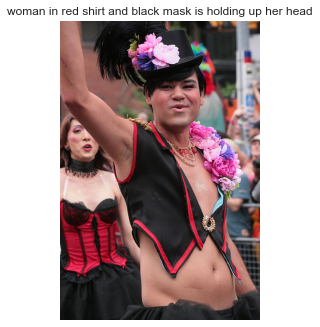

(2048,)


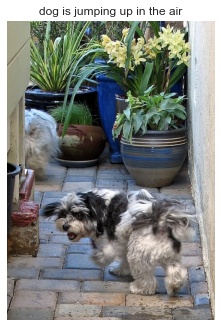

(2048,)


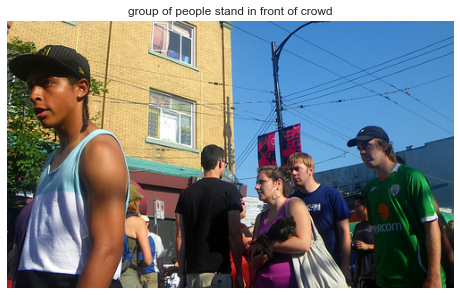

(2048,)


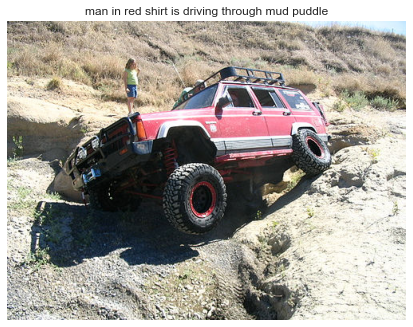

(2048,)


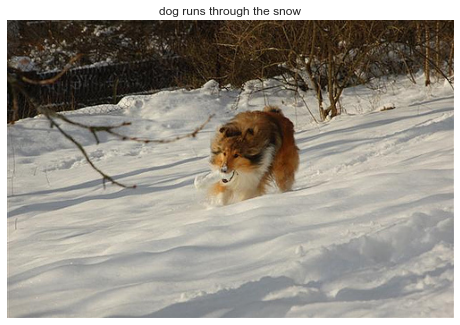

(2048,)


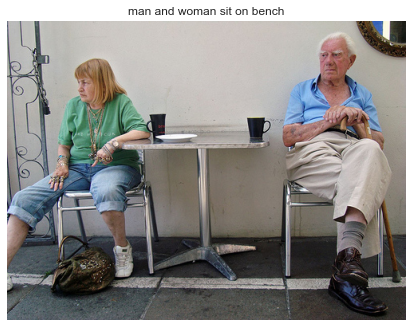

(2048,)


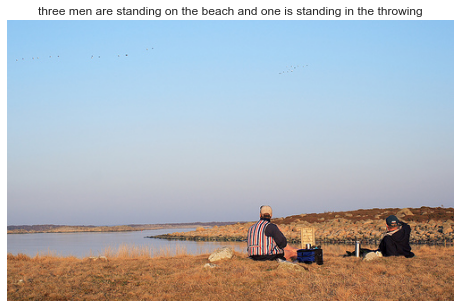

(2048,)


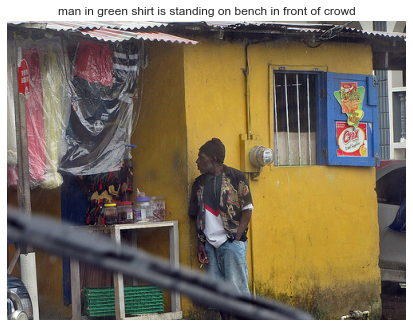

(2048,)


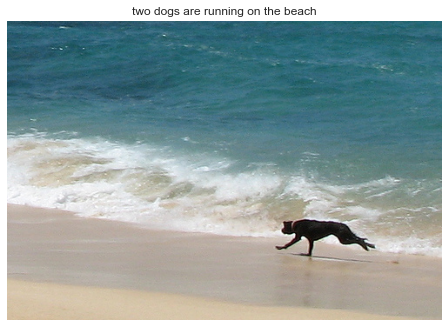

(2048,)


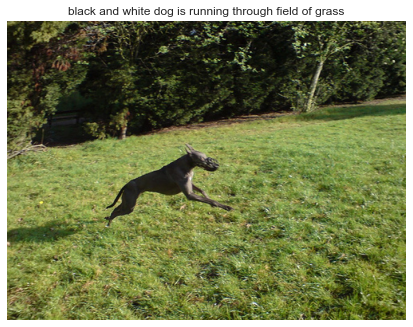

(2048,)


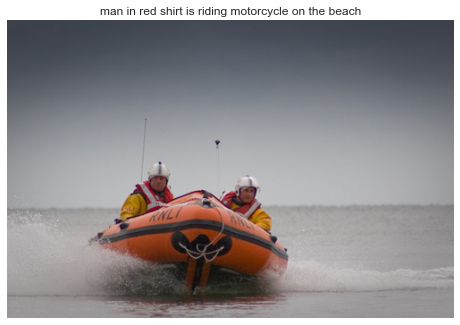

(2048,)


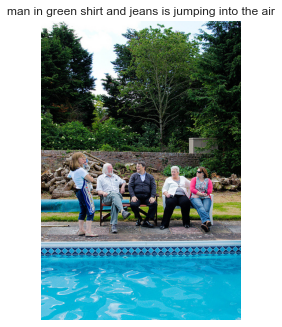

(2048,)


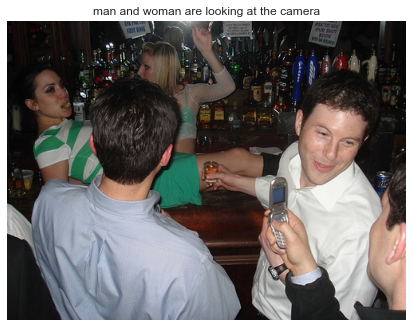

(2048,)


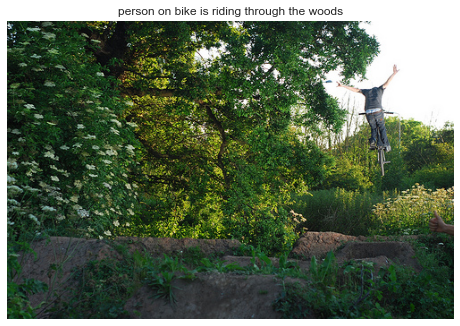

(2048,)


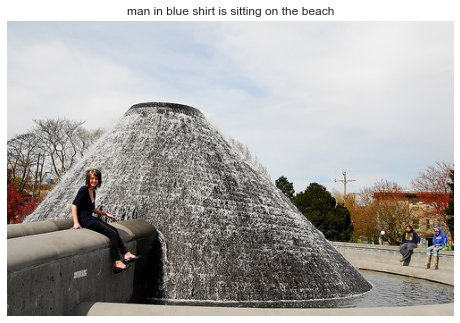

In [52]:
# Pick Some Random Images and See Results
plt.style.use("seaborn")
for i in range(15):
    idx = np.random.randint(0,1000)
    all_img_names = list(encoding_test.keys())
    img_name = all_img_names[idx]
    print(encoding_test[img_name].shape)
    photo_2048 = encoding_test[img_name].reshape((1,2048))
    
    i = plt.imread("Data/Images/"+img_name+".jpg")
    
    caption = predict_caption(photo_2048)
    #print(caption)
    
    plt.title(caption)
    plt.imshow(i)
    plt.axis("off")
    plt.show()
    

In [218]:
#encoding_test["3385593926_d3e9c21170"].shape